In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [37]:
data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/unrate.xlsx', sheet_name = 'data')
data = data.query('observation_date < 2020 & observation_date > 1959')
data = data.dropna().reset_index()
k_ahead = 12
data.head()

,index,observation_date,UNRATE
0,133,1959-02-01,5.9
1,134,1959-03-01,5.6
2,135,1959-04-01,5.2
3,136,1959-05-01,5.1
4,137,1959-06-01,5.0


<ipython-input-39-60593ea3cacb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['log'] = np.log(ts['level'])


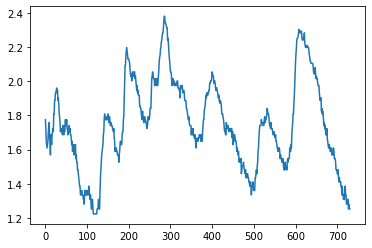

In [39]:
ts = data[['UNRATE']]
ts.columns = ['level']
ts['log'] = np.log(ts['level'])
ts['log'].plot()

# Build Models

# 1-step ahead AR(1) iterated

In [40]:
ts['log_dif'] = ts['log'].diff(1)
ts['k_ldif'] = ts['log'].diff(k_ahead)
ts = ts.dropna()

In [41]:
#Fit 1-step model
arma_model = ARIMA(ts['log_dif'], order=(1, 0, 0)).fit()
print(arma_model.summary())

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                               SARIMAX Results                                
Dep. Variable:                log_dif   No. Observations:                  719
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1510.590
Date:                Mon, 19 Oct 2020   AIC                          -3015.180
Time:                        13:23:30   BIC                          -3001.446
Sample:                             0   HQIC                         -3009.877
                                - 719                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.466      0.641      -0.003       0.002
ar.L1          0.0137      0.031      0.446      0.655      -0.046       0.074
sigma2         0.0009   3.89e-05     22.539      0.0

In [42]:
omega, rho, sigsq =  arma_model.params

year_mean = np.sum([omega*(k_ahead-i)*rho**i for i in range(0,k_ahead)])
year_rho = np.sum([rho**i for i in range(1,k_ahead+1)])
year_var = sigsq*np.sum( [  np.square(np.sum([rho**i for i in range(0,k)])) for k in range(1,k_ahead+1)])

In [43]:
ts['ar_indirect_pred'] =  ( year_mean + year_rho*ts['log_dif']) + ts['log']
ts['ar_indirect_pred'] = ts['ar_indirect_pred'].shift(k_ahead)
ts

,level,log,log_dif,k_ldif,ar_indirect_pred
12,4.8,1.568616,-0.080043,-0.206336,NaN
13,5.4,1.686399,0.117783,-0.036368,NaN
14,5.2,1.648659,-0.037740,0.000000,NaN
15,5.1,1.629241,-0.019418,0.000000,NaN
16,5.4,1.686399,0.057158,0.076961,NaN
...,...,...,...,...,...
726,3.7,1.308333,0.000000,-0.026668,1.328341
727,3.5,1.252763,-0.055570,-0.055570,1.301303
728,3.6,1.280934,0.028171,-0.054067,1.328711
729,3.5,1.252763,-0.028171,-0.055570,1.301303


18.696810271226777

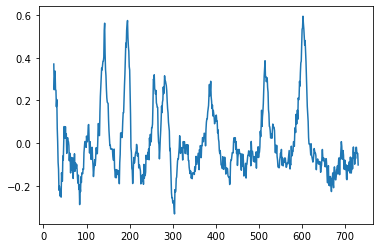

In [44]:
(ts['log']-ts['ar_indirect_pred']).plot()
np.square((ts['log']-ts['ar_indirect_pred'])).sum()

# "Direct Forecast" 

In [46]:
reg_df = ts[['k_ldif']]
reg_df[['year_lag']] = reg_df[['k_ldif']].shift(k_ahead)
reg_df = reg_df.dropna()

X = reg_df['year_lag'].values
Y = reg_df['k_ldif'].values
X = sm.add_constant(X)
direct_model = sm.OLS(Y,X)
results = direct_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     45.07
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           3.92e-11
Time:                        13:23:47   Log-Likelihood:                 302.44
No. Observations:                 707   AIC:                            -600.9
Df Residuals:                     705   BIC:                            -591.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0060      0.006     -1.002      0.3

In [47]:
ts['k_ldif'] 

12    -0.206336
13    -0.036368
14     0.000000
15     0.000000
16     0.076961
         ...   
726   -0.026668
727   -0.055570
728   -0.054067
729   -0.055570
730   -0.108214
Name: k_ldif, Length: 719, dtype: float64

In [48]:
alpha,beta = results.params
direct_sigsq = np.mean(np.square(results.resid))

ts['direct_pred'] = alpha + beta *ts['k_ldif']+ts['log']
ts['direct_pred'] = ts['direct_pred'].shift(k_ahead)

In [49]:
direct_sigsq

0.024886689700137004

17.594889617996863

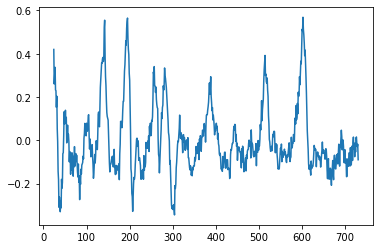

In [50]:
(ts['log']-ts['direct_pred']).plot()
np.square((ts['log']-ts['direct_pred'])).sum()

Text(0.5, 1.0, 'Residuals values')

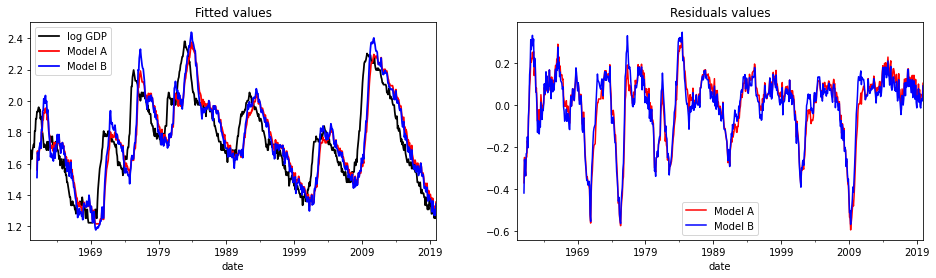

In [52]:
plot_ts = ts.copy()
plot_ts['date']= data.loc[8:]['observation_date']
plot_ts = plot_ts.set_index('date')
fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))

plot_ts[['log','ar_indirect_pred','direct_pred']].plot(ax = axa, linewidth = 1.75, color = ['black','red','blue'])
axa.legend(['log GDP','Model A', 'Model B'])
axa.set_title('Fitted values')

plot_ts[['ar_indirect_pred','direct_pred']].subtract(plot_ts['log'],axis= 0).plot(ax = axb, color = ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Residuals values')

# Compare Forecasts

# KS test for PITS

In [54]:
ts = ts.dropna()
ts

,level,log,log_dif,k_ldif,ar_indirect_pred,direct_pred
24,6.9,1.931521,0.044452,0.362905,1.560846,1.512268
25,6.9,1.931521,0.000000,0.245122,1.681371,1.671561
26,7.0,1.945910,0.014389,0.297252,1.641475,1.642702
27,7.1,1.960095,0.014185,0.330854,1.622311,1.623284
28,6.9,1.931521,-0.028573,0.245122,1.680531,1.699238
...,...,...,...,...,...,...
726,3.7,1.308333,0.000000,-0.026668,1.328341,1.293241
727,3.5,1.252763,-0.055570,-0.055570,1.301303,1.271421
728,3.6,1.280934,0.028171,-0.054067,1.328711,1.310487
729,3.5,1.252763,-0.028171,-0.055570,1.301303,1.271421


In [55]:
indirect_pits = []
direct_pits = []
# indirect_debias_pits = []

for time in ts.index:
    actual = ts.loc[time,'log']
    
    ar_mean = ts.loc[time,'ar_indirect_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
#     indirect_bias = ts.loc[time,'indirect_debias']
    
    indirect_pits.append(scipy.stats.norm.cdf(actual, loc=ar_mean, scale=ar_std) )
    direct_pits.append(scipy.stats.norm.cdf(actual, loc=direct_mean, scale=direct_std) )
#     indirect_debias_pits.append(scipy.stats.norm.cdf(actual, loc=indirect_bias, scale=ar_std) )
    
print(stats.kstest(indirect_pits, 'uniform'))
print(stats.kstest(direct_pits, 'uniform'))
# print(stats.kstest(indirect_debias_pits, 'uniform'))

KstestResult(statistic=0.19673599493305355, pvalue=1.878329235645588e-24)
KstestResult(statistic=0.13834389374814648, pvalue=2.889580984215609e-12)


# KL Divergence

In [58]:
indirect_kl = 0
direct_kl = 0
# indirect_debias_kl = 0


for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_indirect_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    
#     indirect_bias = ts.loc[time,'indirect_debias']

    indirect_kl = indirect_kl + scipy.stats.norm.logpdf(actual, loc=ar_mean, scale=ar_std)
    direct_kl = direct_kl + scipy.stats.norm.logpdf(actual, loc=direct_mean, scale=direct_std)
#     indirect_debias_kl = indirect_debias_kl + scipy.stats.norm.logpdf(actual, loc=indirect_bias, scale=ar_std)

    
print(indirect_kl)
print(direct_kl)
# print(indirect_debias_kl)

84.53860986167886
302.43519363488366


# Coverage of all confidence intervals

In [59]:
coverage_df = pd.DataFrame(columns = ['prob','indirect_ar_pct', 'direct_pct']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    coverage_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_indirect_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )
    

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        
        
        coverage_df.loc[prob] = coverage_df.loc[prob] + [1*(actual > ar_ci[0])*(actual<ar_ci[1]),
                                                           1*(actual > direct_ci[0])*(actual<direct_ci[1]) ]
        
coverage_df = coverage_df.div(len(ts))
coverage_df['theoretical'] = prob_list

Text(0.5, 1.0, 'Scaled empirical Coverage Curve')

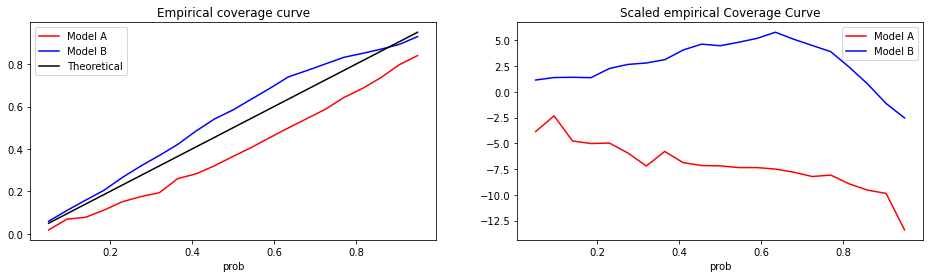

In [60]:
prob_list = coverage_df.index.values

fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))
coverage_df.plot(ax = axa, color =  ['red','blue','black'] )
axa.legend(['Model A', 'Model B', 'Theoretical'])
axa.set_title('Empirical coverage curve')

coverage_df[['indirect_ar_pct','direct_pct']].subtract(prob_list, axis = 0).div(np.sqrt(prob_list*(1-prob_list)), axis = 0).multiply(np.sqrt(len(ts))).plot(ax = axb,color = ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Scaled empirical Coverage Curve')

In [61]:
print(np.square(coverage_df['indirect_ar_pct'] - coverage_df['theoretical']).sum())
print(np.square(coverage_df['direct_pct'] - coverage_df['theoretical']).sum())

0.27260517326232525
0.07794114472570715


# Interval forecast scores

In [62]:
def score(x,lower,upper,prob):
    return (upper-lower) + (2/(1-prob))*(max(x-upper,0) + max(lower-x,0))

In [63]:
score_df = pd.DataFrame(columns = ['prob','indirect_ar_pct', 'direct_pct']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    score_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_indirect_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )

#     indirect_bias = ts.loc[time,'indirect_debias']

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
#         ar_debias_ci = scipy.stats.norm.interval(prob, loc=indirect_bias, scale=ar_std)

        
        score_df.loc[prob] = score_df.loc[prob] + [score(actual, ar_ci[0],ar_ci[1], prob),
                                                   score(actual, direct_ci[0], direct_ci[1], prob) ]
#                                                   score(actual, ar_debias_ci[0],ar_debias_ci[1], prob)]
        
score_df = score_df.div(len(ts))

Text(0.5, 1.0, 'Interval forecast scores')

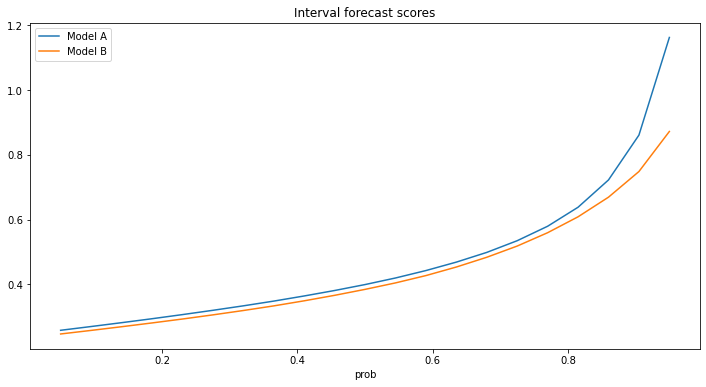

In [64]:
fig, ax = plt.subplots(figsize = (12,6))
score_df.plot(ax = ax)

ax.legend(['Model A','Model B'])
ax.set_title('Interval forecast scores')

In [65]:
print( ar_std, direct_std)

0.10383182980969471 0.15775515744385984


In [66]:
miss_df = pd.DataFrame(columns = ['prob','indirect_miss','indirect_length', 'direct', 'direct_length']).set_index('prob')
prob_list = np.linspace(.05,.95,21)

for prob in prob_list:
    miss_df.loc[prob] = 0.0

for time in ts.index:
    actual = ts.loc[time,'log']
    ar_mean = ts.loc[time,'ar_indirect_pred']
    ar_std = np.sqrt(year_var)
    
    direct_mean = ts.loc[time,'direct_pred']
    direct_std = np.sqrt(direct_sigsq )

    for prob in prob_list:
        ar_ci = scipy.stats.norm.interval(prob, loc=ar_mean, scale=ar_std)
        direct_ci = scipy.stats.norm.interval(prob, loc=direct_mean, scale= direct_std)
        
        
        miss_df.loc[prob] = miss_df.loc[prob] + [max(actual - ar_ci[1],0) + max(ar_ci[0]-actual,0),
                                                 ar_ci[1]-ar_ci[0],
                                                 max(actual - direct_ci[1],0) + max(direct_ci[0]-actual,0),
                                                 direct_ci[1]-direct_ci[0] ]
        
miss_df = miss_df.div(len(ts))

In [67]:
miss_df

,indirect_miss,indirect_length,direct,direct_length
prob,,,,
0.050,0.116146,0.013022,0.107521,0.019785
0.095,0.110580,0.024784,0.099322,0.037655
0.140,0.105096,0.036627,0.091535,0.055648
0.185,0.099694,0.048589,0.084111,0.073823
0.230,0.094439,0.060716,0.077043,0.092247
0.275,0.089261,0.073053,0.070385,0.110992
0.320,0.084130,0.085654,0.064093,0.130136
0.365,0.079109,0.098578,0.058154,0.149773
0.410,0.074256,0.111897,0.052692,0.170008


Text(0.5, 1.0, 'Aveage length of interval')

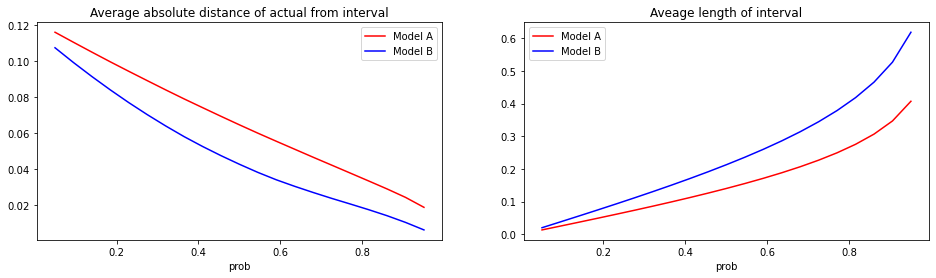

In [68]:
prob_list = coverage_df.index.values

fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))
miss_df[['indirect_miss','direct']].plot(ax = axa, color =  ['red','blue'] )
axa.legend(['Model A', 'Model B'])
axa.set_title('Average absolute distance of actual from interval')

miss_df[['indirect_length','direct_length']].plot(ax = axb, color =  ['red','blue'] )
axb.legend(['Model A', 'Model B'])
axb.set_title('Aveage length of interval')